## Alumno : Rubén Álvarez Mosquera

---
# **Estudio del cálculo de la Prima del Seguro**

*Prefacio : Nuestra tarea consiste en encontrar el mejor modelo de entrenamiento para calcular la prima del seguro*

---

## Declaración de módulos
---

En primer lugar, vamos a importar algunos módulos comunes. 

También comprobamos que Python 3.5 o posterior está instalado (aunque Python 2.x puede funcionar, está obsoleto por lo que es **altamente** recomendable utilizar Python 3 en su lugar), así como Scikit-Learn ≥0.20.

También agregaremos una librería (warnings) para evitar los molestos mensajes de advertencia(Futurewarnings).

In [2]:
# Se requiere Python ≥ 3.5
import sys
assert sys.version_info >= (3, 5)

# Se requiere Scikit-Learn ≥ 0.20
import sklearn
assert sklearn.__version__ >= "0.20"

# Otros imports
import numpy as np
import os

# Importamos la librería Pandas para administar Dataframes
import pandas as pd

# la línea que sigue, sólo en Colab ...
# %matplotlib inline
# Importamos librería MatPlotLib
import matplotlib as mpl
import matplotlib.pyplot as plt

# tamaño del texto en las etiquetas por defecto
mpl.rc('axes',  labelsize=15)
mpl.rc('xtick', labelsize=15)
mpl.rc('ytick', labelsize=15)

# Importamos librería "Seaborn" para la visualización que es como un MatPlotLib con "esteriodes"
import seaborn as sns 


# Importa la librería que va a posibilitar evitar que salgan los molestos mensajes de advertencia
import warnings

Configuración de las Advertencias "Futurewarning"

In [3]:
# configuración para eviatar que aparezcan las advertencias "FutureWarnings"
warnings.filterwarnings("ignore", category=FutureWarning)

Configuración de las visualizaciones de "Seaborn"

In [4]:
# Configuramos visualizaciones con Seaborn
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['font.size'] =14
plt.rcParams['font.weight']= 'bold'
plt.style.use('seaborn-whitegrid')

## Importacion de Datos
---

Definimos la función que importará los datos de un archivo CSV a un Dataframe de Pandas

In [5]:
INSURANCE_PATH = os.path.join("datasets", "insurance");

def load_insurance_data(insurance_path):
    csv_path = os.path.join(insurance_path, "insurance.csv")
    return pd.read_csv(csv_path)

Llamamos a la función de importación de datos y los importamos a la variable "insurance"

In [6]:
insurance = load_insurance_data(INSURANCE_PATH)

Comprobamos el estado de los Datos, mediante una revisión de las primeras filas

In [7]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0,yes,southwest,16884.92400
1,18.0,male,33.770,1,no,southeast,1725.55230
2,28.0,male,33.000,3,no,southeast,4449.46200
3,33.0,male,22.705,0,no,northwest,21984.47061
4,32.0,male,28.880,0,no,northwest,3866.85520


Comprobamos la información del Dataframe

In [8]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   float64
 1   sex       1338 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 73.3+ KB


Comprobamos un resumen descriptivo general del Dataframe

In [9]:
insurance.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1338.000000,1338.000000
mean,39.208676,30.664589,1.094918,13270.422265
std,14.055088,6.100313,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.700000,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## Revisamos el estado de los datos : Gestión de los NaN del DataSet
---

Comprobación del número de NaN por categoría

In [10]:
# De forma global
insurance.isna().sum()

age         1
sex         0
bmi         1
children    0
smoker      1
region      0
charges     0
dtype: int64

Podemos ver como tenemos varios NaN repartidos
* age 1
* bmi 1
* smoker 1

Realizamos una copia del dataset por si fuera necesario recuperar el original

In [11]:
insurance_backup = insurance.copy()

*En el caso de la edad (age), pondremos la media*

In [12]:
# Hallamos la media redondeada a años
media_age = round(insurance["age"].mean(),0)
print("La media redondeada a años es: ", round(insurance["age"].mean(),0))
# Localizamos el índice del NaN
lista_NaN_age = list(insurance.loc[pd.isna(insurance["age"]), :].index)
print("Lista de los índices con NaN : ", list(insurance.loc[pd.isna(insurance["age"]), :].index))
# Cambiamos el valor de los índice para la columna añoas por la media
for x in lista_NaN_age:
    insurance.loc[x,'age']=media_age

#Revisamos resultados 
print("Después de los cambios, el número de los NaN en la columna 'age' es de : ", insurance["age"].isna().sum())


La media redondeada a años es:  39.0
Lista de los índices con NaN :  [750]
Después de los cambios, el número de los NaN en la columna 'age' es de :  0


*En el caso del índice de masa corporal (bmi), pondremos la media*

In [13]:
# Hallamos la media redondeada a tres decimales
media_bmi = round(insurance["bmi"].mean(),3)
print("La media redondeada de índice de masa corporal es: ", round(insurance["bmi"].mean(),3))
# Localizamos el índice del NaN
lista_NaN_bmi = list(insurance.loc[pd.isna(insurance["bmi"]), :].index)
print("Lista de los índices con NaN : ", list(insurance.loc[pd.isna(insurance["bmi"]), :].index))
# Cambiamos el valor de los índice para la columna añoas por la media
for x in lista_NaN_bmi:
    insurance.loc[x,'bmi']=media_bmi

#Revisamos resultados 
print("Después de los cambios, el número de los NaN en la columna 'bmi' es de: ", insurance["bmi"].isna().sum())

La media redondeada de índice de masa corporal es:  30.665
Lista de los índices con NaN :  [1337]
Después de los cambios, el número de los NaN en la columna 'bmi' es de:  0


*En el caso de fumador/no fumador, miraremos cual es la opción mayoritaria y pondremos esa en el caso concreto de NaN*

In [14]:
# Revisaremos las dos opciones, y las contaremos
print("El número de valores de fumadores y no fumadores es :\n", insurance["smoker"].value_counts())
# Vemos que la opción mayoritaria es NO fumador, por lo que cambiaremos el NaN por un "no"
# Localizamos el índice del NaN
lista_NaN_smoker = list(insurance.loc[pd.isna(insurance["smoker"]), :].index)
print("Lista de los índices con NaN : ", list(insurance.loc[pd.isna(insurance["smoker"]), :].index))
# Cambiamos el valor de los índice para la columna añoas por la media
for x in lista_NaN_smoker:
    insurance.loc[x,'smoker']="no"

#Revisamos resultados 
print("Después de los cambios, el número de los NaN en la columna 'smoker' es de : ", insurance["smoker"].isna().sum())


El número de valores de fumadores y no fumadores es :
 no     1063
yes     274
Name: smoker, dtype: int64
Lista de los índices con NaN :  [681]
Después de los cambios, el número de los NaN en la columna 'smoker' es de :  0


Finalmente, revisamos la lista total de NaN por categoría, para asegurarnos que no queda ninguno sin tratar.

In [15]:
# Revisamos de nuevo los NaN de forma global
insurance.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

## Revisión y tratamiento de las columnas categorizadas : Sex, Smoker y Region
---


Revisaremos las tres categorías, agregando la columna a una variable que usaremos posteriormente, y revisaremos el tipo de las categorías y sus valores

### Sex

In [16]:
# agregamos la columna a una variable
cat_sexo = insurance[ ["sex"] ]

# Revisamos el contenido de la columna
insurance["sex"].value_counts()


male      676
female    662
Name: sex, dtype: int64

### Smoker

In [17]:
# agregamos la columna a una variable
cat_fumador = insurance[ ["smoker"] ]

# Revisamos el contenido de la columna
insurance["smoker"].value_counts()


no     1064
yes     274
Name: smoker, dtype: int64

### Region

In [18]:
# agregamos la columna a una variable
cat_region = insurance[ ["region"] ]

# Revisamos el contenido de la columna
insurance["region"].value_counts()



southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

Podemos observar que son columnas categarizadas, que para el entrenamiento no pueden existir, por lo que necesitamos pasar de columnas categorizadas a otro tipo de expresión como por ejemplo a la división de las categorías en nuevas columnas y poniendo un 0 cuando no se cumpla la condición de la categoría y un "1" cuando sí.

De esta forma no estaremos añadiendo información al Dataset, y nos permitirá el estudio y el entrenamiento del modelo.

## Uso de OneHotEncoder para la gestión de las cloumnas categorizadas
---

OneHotencoder nos permitirá pasar las categorías a diferentes columnas por valor de categoría y agregarle "0" y "1" en cada caso.

Ante de nada realizaremos un Backup de los datos por si necesitáramos volver al estado anterior

In [19]:
# Haremos una copia para ver los resultados 
insurance_backup = insurance.copy()

Crearemos una nueva variable con el Dataframe Normalizado llamdo "insurance_norm"

In [20]:
insurance_norm = insurance.copy()

Llamamos a la librería "OneHotEncoder" de Sklearn

In [21]:
# Declaramos la librería OneHotEncoder de sklearn
from sklearn.preprocessing import OneHotEncoder

Usamos el método con cada una de las columnas categóricas, empezando por


### SEXO

In [22]:
sexo_encoder =OneHotEncoder(sparse=False)
# para la categoria Sexo (male/female)
sexo_cat_1hot = sexo_encoder.fit_transform(cat_sexo)

sexo_cat_1hot

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [23]:
# Aquí tendremos los nombre de las categorías
sexo_encoder.categories_

[array(['female', 'male'], dtype=object)]

In [24]:

# Ahora sustituiremos la columna Sexo , por las de OneHotEncoder
insurance_norm.reset_index(drop=False, inplace=True)
insurance_norm=insurance_norm.join(pd.DataFrame(sexo_cat_1hot, columns=[cat for cat in sexo_encoder.categories_[0]]))
# Borraremos la columna categorizada, así como el index que se añadió al realizar el join 
insurance_norm=insurance_norm.drop(["sex","index"], axis=1)
# Mostramos el resultado
insurance_norm.info()
insurance_norm.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   float64
 1   bmi       1338 non-null   float64
 2   children  1338 non-null   int64  
 3   smoker    1338 non-null   object 
 4   region    1338 non-null   object 
 5   charges   1338 non-null   float64
 6   female    1338 non-null   float64
 7   male      1338 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 83.8+ KB


,age,bmi,children,smoker,region,charges,female,male
0,19.0,27.900,0,yes,southwest,16884.92400,1.0,0.0
1,18.0,33.770,1,no,southeast,1725.55230,0.0,1.0
2,28.0,33.000,3,no,southeast,4449.46200,0.0,1.0
3,33.0,22.705,0,no,northwest,21984.47061,0.0,1.0
4,32.0,28.880,0,no,northwest,3866.85520,0.0,1.0


### FUMADOR

In [25]:
fumador_encoder = OneHotEncoder(sparse=False)
# para la categoria Fumador (no/yes)
fumador_cat_1hot = fumador_encoder.fit_transform(cat_fumador)

insurance_norm.reset_index(drop=False, inplace=True)
insurance_norm=insurance_norm.join(pd.DataFrame(fumador_cat_1hot, columns=[cat for cat in fumador_encoder.categories_[0]]))
# Borraremos la columna categorizada, así como el index que se añadió al realizar el join
insurance_norm=insurance_norm.drop(["smoker","index"], axis=1)

# Mostramos el resultado
insurance_norm.info()
insurance_norm.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   float64
 1   bmi       1338 non-null   float64
 2   children  1338 non-null   int64  
 3   region    1338 non-null   object 
 4   charges   1338 non-null   float64
 5   female    1338 non-null   float64
 6   male      1338 non-null   float64
 7   no        1338 non-null   float64
 8   yes       1338 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 94.2+ KB


,age,bmi,children,region,charges,female,male,no,yes
0,19.0,27.900,0,southwest,16884.92400,1.0,0.0,0.0,1.0
1,18.0,33.770,1,southeast,1725.55230,0.0,1.0,1.0,0.0
2,28.0,33.000,3,southeast,4449.46200,0.0,1.0,1.0,0.0
3,33.0,22.705,0,northwest,21984.47061,0.0,1.0,1.0,0.0
4,32.0,28.880,0,northwest,3866.85520,0.0,1.0,1.0,0.0


En este caso también le cambiaremos el nombre(label) de las columnas , para un mejor entendimiento

In [26]:
# Cambiamos el nombre d elas columnas para entenderlo mejor
insurance_norm=insurance_norm.rename(columns={"no":"no smoker"});
insurance_norm=insurance_norm.rename(columns={"yes":"smoker"});

# Revisamos cambios 
insurance_norm.head()

,age,bmi,children,region,charges,female,male,no smoker,smoker
0,19.0,27.900,0,southwest,16884.92400,1.0,0.0,0.0,1.0
1,18.0,33.770,1,southeast,1725.55230,0.0,1.0,1.0,0.0
2,28.0,33.000,3,southeast,4449.46200,0.0,1.0,1.0,0.0
3,33.0,22.705,0,northwest,21984.47061,0.0,1.0,1.0,0.0
4,32.0,28.880,0,northwest,3866.85520,0.0,1.0,1.0,0.0


In [27]:
# para la categoria Region (southeast/southwest/northwest/northeast)
region_encoder = OneHotEncoder(sparse=False) 
region_cat_1hot = region_encoder.fit_transform(cat_region)

insurance_norm.reset_index(drop=False, inplace=True)
insurance_norm=insurance_norm.join(pd.DataFrame(region_cat_1hot, columns=[cat for cat in region_encoder.categories_[0]]))
# Borraremos la columna categorizada, así como el index que se añadió al realizar el join
insurance_norm=insurance_norm.drop(["region","index"], axis=1)

# Mostramos el resultado
insurance_norm.info()
insurance_norm.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        1338 non-null   float64
 1   bmi        1338 non-null   float64
 2   children   1338 non-null   int64  
 3   charges    1338 non-null   float64
 4   female     1338 non-null   float64
 5   male       1338 non-null   float64
 6   no smoker  1338 non-null   float64
 7   smoker     1338 non-null   float64
 8   northeast  1338 non-null   float64
 9   northwest  1338 non-null   float64
 10  southeast  1338 non-null   float64
 11  southwest  1338 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 125.6 KB


,age,bmi,children,charges,female,male,no smoker,smoker,northeast,northwest,southeast,southwest
0,19.0,27.900,0,16884.92400,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,18.0,33.770,1,1725.55230,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,28.0,33.000,3,4449.46200,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,33.0,22.705,0,21984.47061,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,32.0,28.880,0,3866.85520,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


### Revisamos el resultado final : está todo correcto

In [28]:
insurance_norm.head()

,age,bmi,children,charges,female,male,no smoker,smoker,northeast,northwest,southeast,southwest
0,19.0,27.900,0,16884.92400,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,18.0,33.770,1,1725.55230,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,28.0,33.000,3,4449.46200,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,33.0,22.705,0,21984.47061,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,32.0,28.880,0,3866.85520,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


## Revisión de los histogramas de las columnas
---

Realizamos una visualización de los histogramas de los datos, que representan el número de veces que un valor aparece, representando la distribución de los casos por categoría para tener una idea de su cantidad, dispersión ,etc...

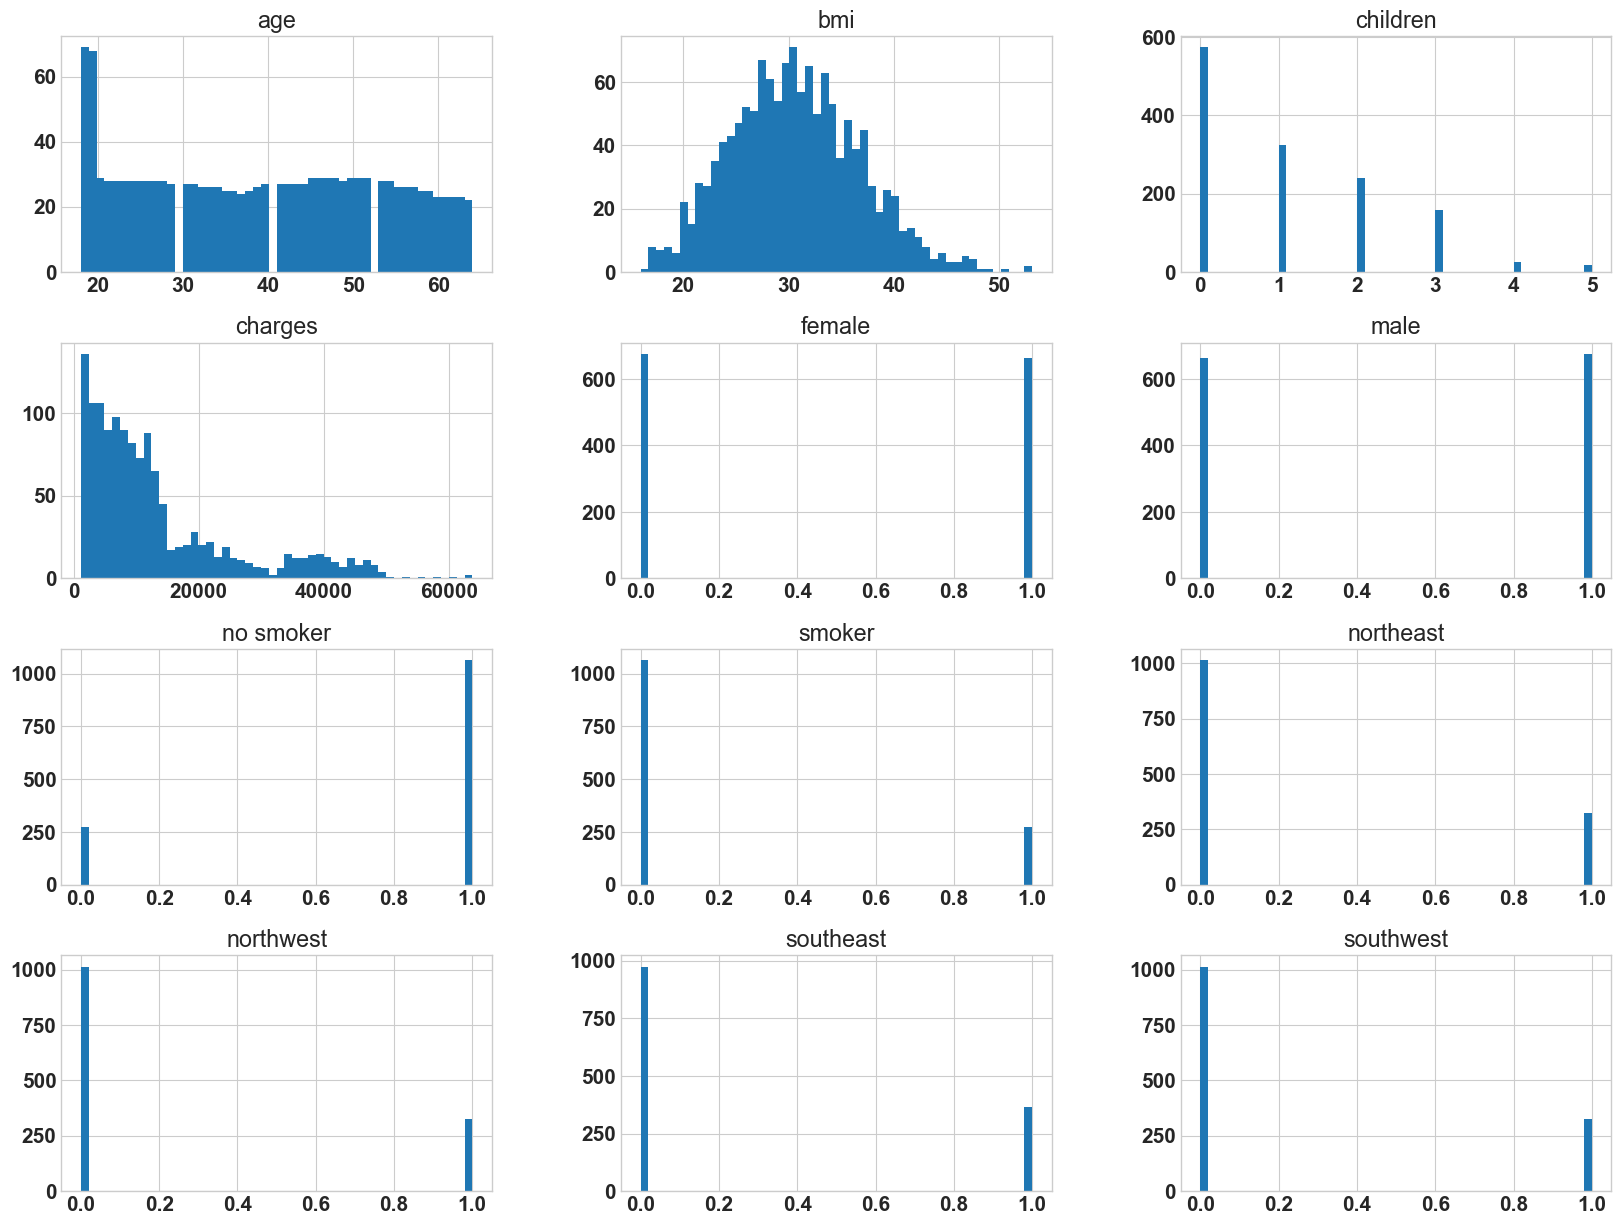

In [29]:
insurance_norm.hist(bins=50, figsize =(20,15))
plt.show()

Los histogramas tienen un buen comportamiento con categorías discretas, pero no tanto con las categóricas, que apenas nos arrojan datos, a parte de su distribución por categorías

De todas formas, podemos ver que:
- Edad : Hay una gran concentración de muestras en edades de 18 a 20 años
- BMI(Índice de Masa Corporal) : Tiene una dispersión normal (Campana de Gauss)
- Hijos : Existen más concentración de muestras cuantos menos hijos, siendo "0" la mayor de ellas
- Cargos : Hay una gran concentración de muestras en las más bajas hasta 15.000
- Sexo : Igual número (aproximado) de hombre y mujeres
- Fumadores : Mucha más concentración de NO fumadores ( casi tres veces más )
- Región : Aproximadamente numero igual de muestras en cada region

## Estudio numérico de la correlación entre los datos para obtener información relevante
---

### Buscando correlaciones

Mostramos las correlaciones en formato del modelo Normalizado y NO normalizado

Aquí nos damos cuenta de la necesidad de la normalización del modelo para que las correlaciones puedan ser medidas

In [30]:
corr_matrix = insurance.corr()
corr_matrix["charges"].sort_values(ascending=False)

charges     1.000000
age         0.299066
bmi         0.198602
children    0.067998
Name: charges, dtype: float64

In [31]:
corr_matrix

,age,bmi,children,charges
age,1.000000,0.109505,0.042373,0.299066
bmi,0.109505,1.000000,0.012582,0.198602
children,0.042373,0.012582,1.000000,0.067998
charges,0.299066,0.198602,0.067998,1.000000


In [32]:
corr_matrix_norm = insurance_norm.corr()
corr_matrix_norm["charges"].sort_values(ascending=False)

charges      1.000000
smoker       0.787251
age          0.299066
bmi          0.198602
southeast    0.073982
children     0.067998
male         0.057292
northeast    0.006349
northwest   -0.039905
southwest   -0.043210
female      -0.057292
no smoker   -0.787251
Name: charges, dtype: float64

In [33]:
corr_matrix_norm

,age,bmi,children,charges,female,male,no smoker,smoker,northeast,northwest,southeast,southwest
age,1.000000,0.109505,0.042373,0.299066,0.020964,-0.020964,0.024809,-0.024809,0.002415,-0.000468,-0.011468,0.009956
bmi,0.109505,1.000000,0.012582,0.198602,-0.046175,0.046175,-0.004136,0.004136,-0.138270,-0.135654,0.269912,-0.006316
children,0.042373,0.012582,1.000000,0.067998,-0.017163,0.017163,-0.007673,0.007673,-0.022808,0.024806,-0.023066,0.021914
charges,0.299066,0.198602,0.067998,1.000000,-0.057292,0.057292,-0.787251,0.787251,0.006349,-0.039905,0.073982,-0.043210
female,0.020964,-0.046175,-0.017163,-0.057292,1.000000,-1.000000,0.076185,-0.076185,0.002425,0.011156,-0.017117,0.004184
male,-0.020964,0.046175,0.017163,0.057292,-1.000000,1.000000,-0.076185,0.076185,-0.002425,-0.011156,0.017117,-0.004184
no smoker,0.024809,-0.004136,-0.007673,-0.787251,0.076185,-0.076185,1.000000,-1.000000,-0.002811,0.036945,-0.068498,0.036945
smoker,-0.024809,0.004136,0.007673,0.787251,-0.076185,0.076185,-1.000000,1.000000,0.002811,-0.036945,0.068498,-0.036945
northeast,0.002415,-0.138270,-0.022808,0.006349,0.002425,-0.002425,-0.002811,0.002811,1.000000,-0.320177,-0.345561,-0.320177
northwest,-0.000468,-0.135654,0.024806,-0.039905,0.011156,-0.011156,0.036945,-0.036945,-0.320177,1.000000,-0.346265,-0.320829


Mostramos las mismas correlaciones con el modelo gráfico de Seaborn de "Heatmap"

<AxesSubplot:>

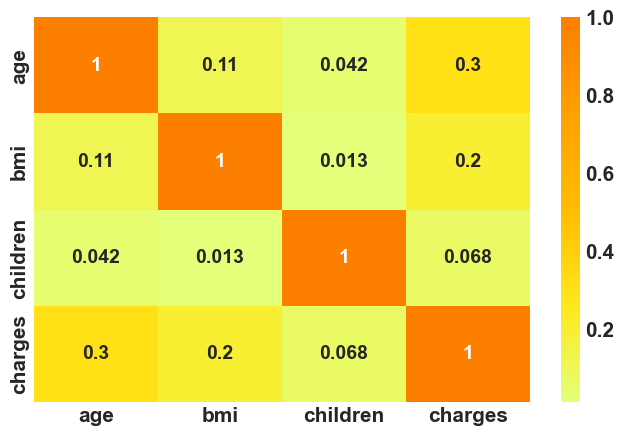

In [34]:
plt.rcParams['font.size'] =14
corr = insurance.corr()
sns.heatmap(corr, cmap = 'Wistia', annot= True)

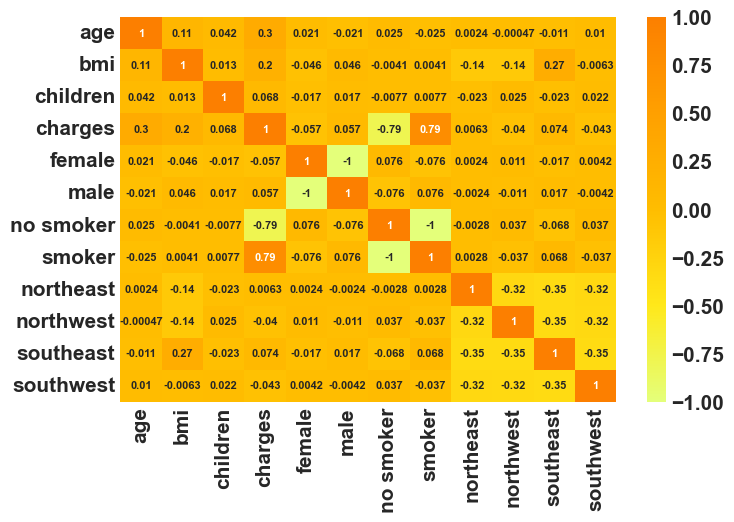

In [35]:
corr_norm = insurance_norm.corr()
# Reduciremos el tamaño de fuente para este gráfico (y lo volveremos a dejar como estaba) por el tamaño de celdas
plt.rcParams['font.size'] =8
sns.heatmap(corr_norm, cmap = 'Wistia', annot= True)
plt.rcParams['font.size'] =14

### Conclusiones Preliminares
---

Podemos observar que en las correlaciones detaca que:
- Existe una correlación muy grande entre Prima y Fumadores 0.787251 ~0.8
- Seguida de una correlación menor con Prima y Edad 0.299066 ~0.3
- Con menos fuerza, tenemos una relación entre Prima y BMI 0.198602 ~0.2
- También tenemos una curiosa relacion entre la region "Southeast" y BMI de un nada despreciable 0.27
- Por último podemos destacar una débil relación entre Edad y BMI de 0.11 

## Visualización de los datos para obtener información relevante
---

Usaremos la visualización de "Scatter Matrix" de Pandas, para revisar las posibles relaciones lineales entre categorías

Para ello llamamos a la librería y agregamos algunas de las categorías numericas

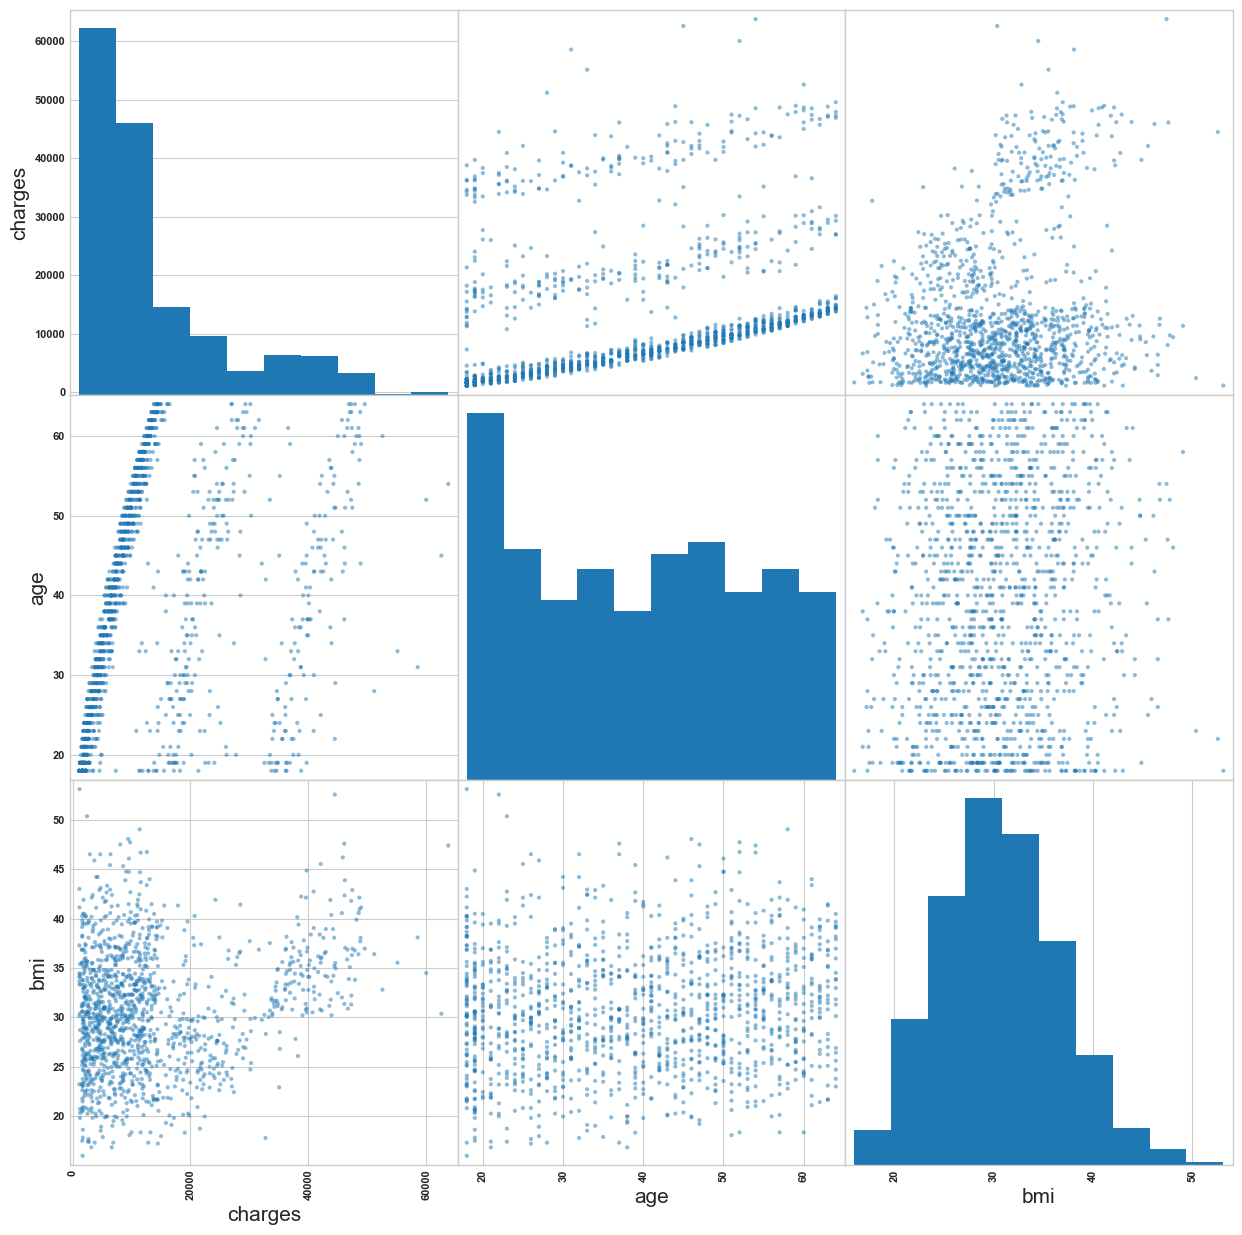

In [36]:
from pandas.plotting import scatter_matrix;

attributes = ["charges","age", "bmi"]

scatter_matrix(insurance_norm[attributes], figsize=(15,15) );

### Revisamos la correlación entre Prima de seguro y Edad, con colores para Fumadores
---

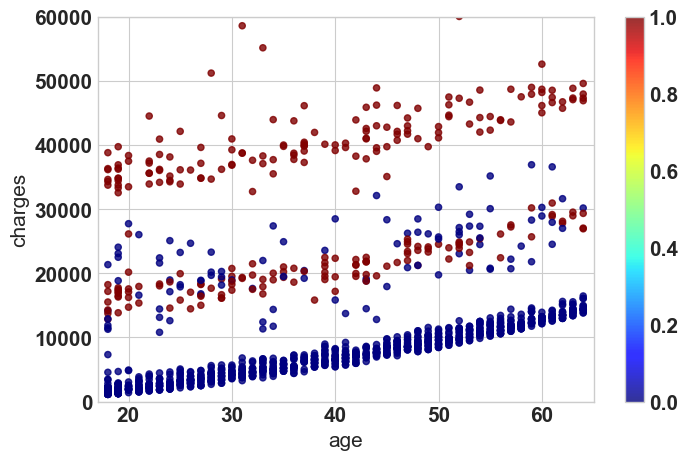

In [37]:

insurance_norm.plot(kind="scatter", 
             x= "age",
             y = "charges",
             c=insurance_norm["smoker"],
             cmap = plt.get_cmap("jet"),
             alpha=0.8)

plt.axis([17,65,0,60000]);

### Conclusión :

Podemos observar que existe una relación lineal positiva entre el precio de la prima del seguro y la edad.

En mayor medida entre los que fuman, llegando a pagar el doble e incluso el triple

---

### Revisamos la correlación entre Prima de seguro y BMI, con colores para Fumadores
---

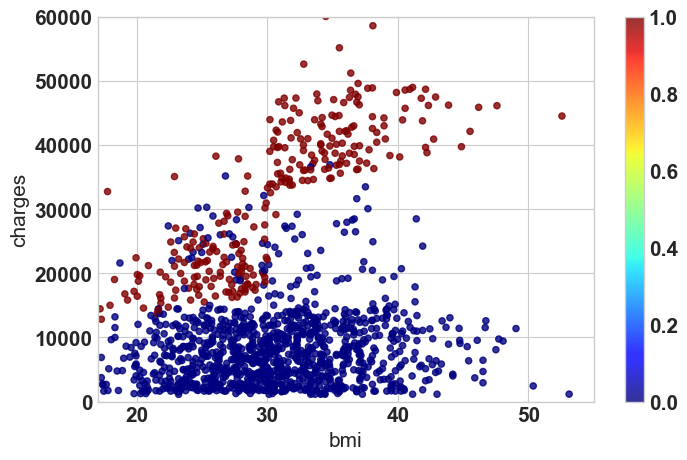

In [38]:

insurance_norm.plot(kind="scatter", 
             x= "bmi",
             y = "charges",
             c=insurance_norm["smoker"],
             cmap = plt.get_cmap("jet"),
             alpha=0.8)

plt.axis([17,55,0,60000]);

### Conclusión:
Podemos observar que existe una relación lineal positiva entre el precio de la prima del seguro y en mayor medida entre los que fuman, llegando a pagar el doble e incluso el triple
Podemos observar claramente que la edad juega un factor muy importante, y que la diferencia entre fumadores y no fumadores es muy grande.
También que la condición de estar por encima de un índice de bmi superior a 30, dispara la correlación lineal entre BMI y prima para los Fumadores

---
---

### Agregamos una nueva columna separando los que tengan más y menos de 30 de BMI

In [39]:

insurance['BMI_below_30'] = np.where(insurance['bmi']<30,'yes', 'no') 
insurance_norm['BMI_below_30'] = np.where(insurance['bmi']<30, 1, 0) 


### Aplicamos un filtro de fumadores y no fumadores 
Como no podemos ver con claridad las clasificaciones binarias de las columnas categorizadas ni binarias, crearemos nuevos dataframes categorizados para usarlos con los gráficos , para ver la fuerte correlación entre fumadores y las cargas de seguro.

In [40]:
# Filtramos los fumadores
filter_smoker = insurance[(insurance['smoker']=='yes')]
filter_no_smoker = insurance[(insurance['smoker']=='no')]

filter_smoker_norm = insurance_norm[(insurance_norm['smoker']==1)]
filter_no_smoker_norm = insurance_norm[(insurance_norm['smoker']==0)]



### Aplicamo un filtro sobre la masa corporal BMI <30 y >30

In [41]:
# Filtramos los fumadores
below30_bmi = filter_smoker[(filter_smoker['bmi']<30)]
upper30_bmi = filter_smoker[(filter_smoker['bmi']>=30)]

below30_bmi_norm = filter_smoker_norm[(filter_smoker_norm['bmi']<30)]
upper30_bmi_norm = filter_smoker_norm[(filter_smoker_norm['bmi']>=30)]

# Filtramos los NO fumadores
below30_bmi_ns = filter_no_smoker[(filter_no_smoker['bmi']<30)]
upper30_bmi_ns = filter_no_smoker[(filter_no_smoker['bmi']>=30)]

below30_bmi_norm_ns = filter_no_smoker_norm[(filter_no_smoker_norm['bmi']<30)]
upper30_bmi_norm_ns = filter_no_smoker_norm[(filter_no_smoker_norm['bmi']>=30)]

---
---

### Con los datos filtrados por fumadores y BMI, podemos ver las visualizaciones más claramente y sacar más conclusiones

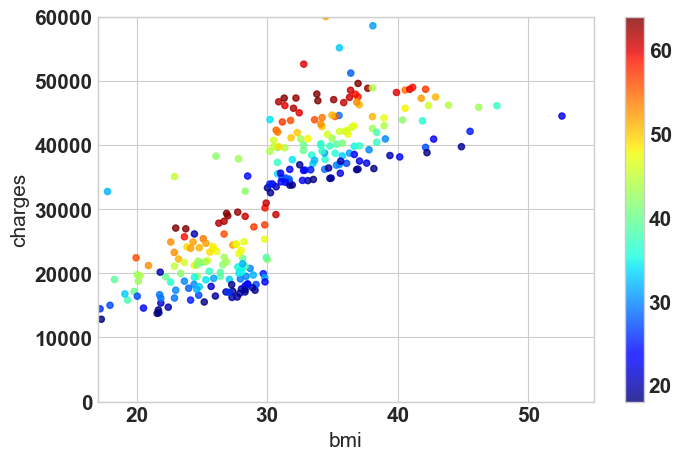

In [42]:
filter_smoker_norm.plot(kind="scatter", 
             x= "bmi",
             y = "charges",
             c=filter_smoker_norm["age"],
             cmap = plt.get_cmap("jet"),
             alpha=0.8)

plt.axis([17,55,0,60000]);

Aquí podemos ver claramente el gap dentro de los fumadores, entre los que están por debajo de 30 de BMI y por encima de BMI

---

## Líneas de tendencia y coeficientes de correlación lineal
---
---

### Para estas mediciones usaremos graficos de dispersión "scatter", con lineas de tendencia central e índices de correlación , como los de Pearson, Spearman y Kendall

En este caso no usaremos Pearson , porque ciertos parámetros no tienen una distribución normal

Los coeficientes de correlación lineal son estadísticos que cuantifican la asociación lineal entre dos variables numéricas. Existen diferentes tipos, de entre los que destacan Rho de Spearman y Tau de Kendall. Todos ellos comparten que:

Su valor está comprendido en el rango [+1 , -1]. Siendo +1 una correlación positiva perfecta y -1 una correlación negativa perfecta.

Se emplean como medida de la fuerza de asociación entre dos variables (tamaño del efecto):

- 0: asociación nula.
- 0.1: asociación pequeña.
- 0.3: asociación mediana.
- 0.5: asociación moderada.
- 0.7: asociación alta.
- 0.9: asociación muy alta.

## Prima VS BMI : Fumadores y No Fumadores

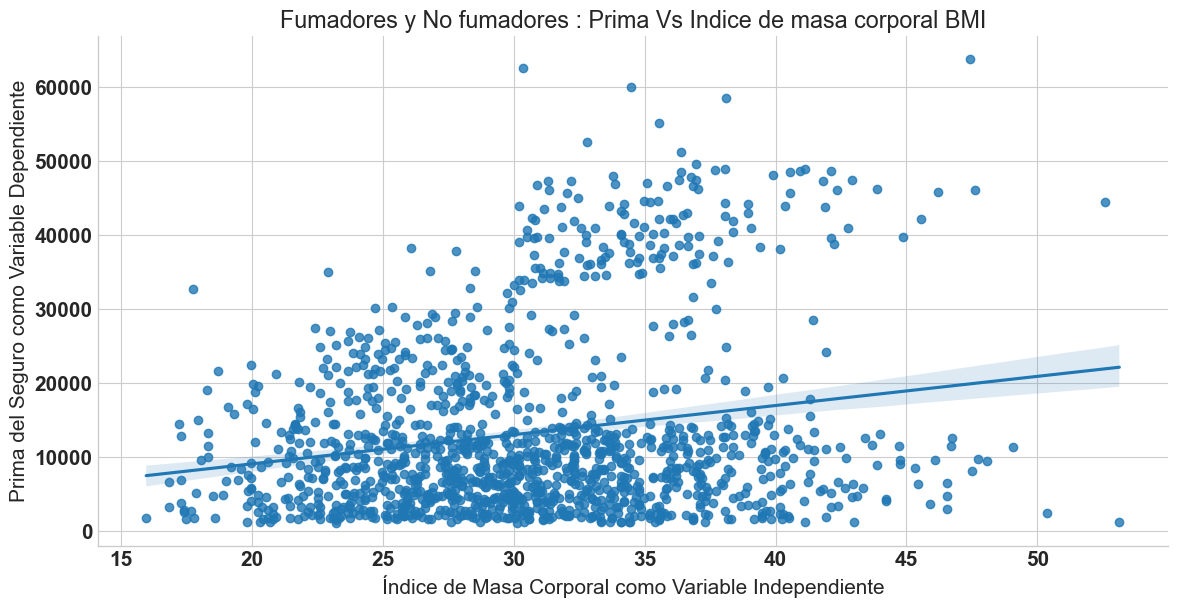

In [64]:
sns.lmplot(x='bmi',y='charges',data=insurance,aspect=2,height=6)
plt.xlabel('Índice de Masa Corporal como Variable Independiente')
plt.ylabel('Prima del Seguro como Variable Dependiente')
plt.title('Fumadores y No fumadores : Prima Vs Indice de masa corporal BMI');


In [44]:

print('Correlación spearman: ', insurance['charges'].corr(insurance['bmi'], method='spearman'))
print('Correlación kendall: ', insurance['charges'].corr(insurance['bmi'], method='kendall'))

Correlación spearman:  0.11975981349776336
Correlación kendall:  0.0827600589416769


### Conclusiones : 
- Correlación entre Prima VS BMI es positiva, pero modesta entre la muestra de Fumadores y no fumadores
---

## Prima VS BMI : Separación entre Fumadores y no fumadores

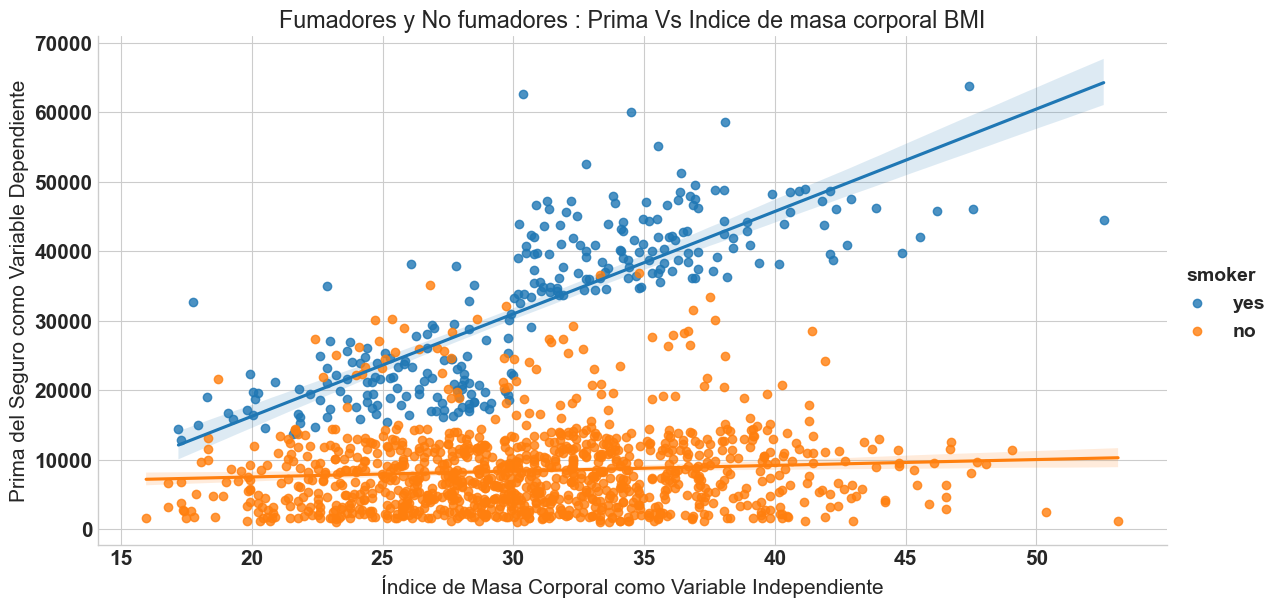

In [45]:

sns.lmplot(x='bmi',y='charges',hue='smoker',data=insurance,aspect=2,height=6)
plt.xlabel('Índice de Masa Corporal como Variable Independiente')
plt.ylabel('Prima del Seguro como Variable Dependiente')
plt.title('Fumadores y No fumadores : Prima Vs Indice de masa corporal BMI');

In [46]:
print()
print('Resultados para NO FUMADORES')
print('============================')

print('Correlación spearman: ', filter_no_smoker['charges'].corr(filter_no_smoker['bmi'], method='spearman'))
print('Correlación kendall: ', filter_no_smoker['charges'].corr(filter_no_smoker['bmi'], method='kendall'))
print()
print('Resultados para FUMADORES')
print('============================')

print('Correlación spearman: ', filter_smoker['charges'].corr(filter_smoker['bmi'], method='spearman'))
print('Correlación kendall: ', filter_smoker['charges'].corr(filter_smoker['bmi'], method='kendall'))
print()


Resultados para NO FUMADORES
Correlación spearman:  0.10513217579871395
Correlación kendall:  0.07112282296341371

Resultados para FUMADORES
Correlación spearman:  0.8341670346036903
Correlación kendall:  0.6221451620359147



### Conclusiones : 
- Aquí podemos ver claramente la necesidad de filtrar los datos, para revelar información subyacente.
- La Correlación entre Prima VS BMI en NO FUMADORES es practicamente insignificante , rondando en el mejor de los casos 0.1
- En cambio la Correlación entre Prima VS BMI dentro de la FUMADORES es claramente positiva, con valores que rondan el 0.8 
- Las dispersiones de las correlaciones son menores en los valores de BMI de 30, y mayores por debajo y por encima.
- Podemos notar una dispersión mayor en el caso de los FUMADORES por encima de 40 de BMI
---

## Prima VS BMI :   NO FUMADORES con más y menos de 30 de BMI

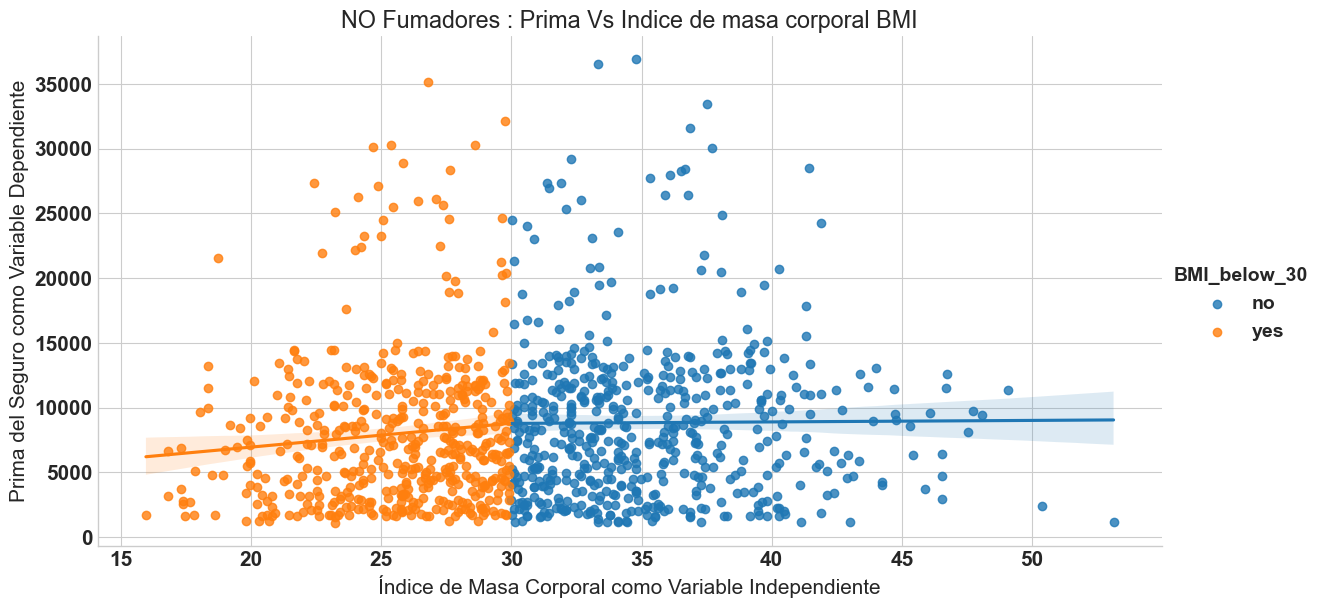

In [47]:
sns.lmplot(x='bmi',y='charges',hue='BMI_below_30',data=filter_no_smoker,aspect=2,height=6)
plt.xlabel('Índice de Masa Corporal como Variable Independiente')
plt.ylabel('Prima del Seguro como Variable Dependiente')
plt.title('NO Fumadores : Prima Vs Indice de masa corporal BMI');

In [48]:
print()
print('Resultados para NO FUMADORES por debajo de 30 de BMI')
print('============================')

print('Correlación spearman: ', below30_bmi_ns['charges'].corr(below30_bmi_ns['bmi'], method='spearman'))
print('Correlación kendall: ', below30_bmi_ns['charges'].corr(below30_bmi_ns['bmi'], method='kendall'))
print()
print('Resultados para NO FUMADORES por encima de 30 de BMI')
print('============================')

print('Correlación spearman: ', upper30_bmi_ns['charges'].corr(upper30_bmi_ns['bmi'], method='spearman'))
print('Correlación kendall: ', upper30_bmi_ns['charges'].corr(upper30_bmi_ns['bmi'], method='kendall'))
print()


Resultados para NO FUMADORES por debajo de 30 de BMI
Correlación spearman:  0.09401155650373715
Correlación kendall:  0.06263986068436929

Resultados para NO FUMADORES por encima de 30 de BMI
Correlación spearman:  0.04200313092975506
Correlación kendall:  0.02823280482023637



### Conclusiones : 
- Como podemos observar las correlaciones son insignificantes entre Prima y BMI para los Fumadores, tanto para los por debajoo por encima de 30 BMI
- Las dispersiones de las correlaciones son menores en los valores de BMI de 30, y mayores por debajo y por encima.
- Podemos notar una dispersión mayor por debajo de 22 y muy acentuada por debajo de 45 de BMI
---

## Prima VS BMI :  FUMADORES con más y menos de 30 de BMI

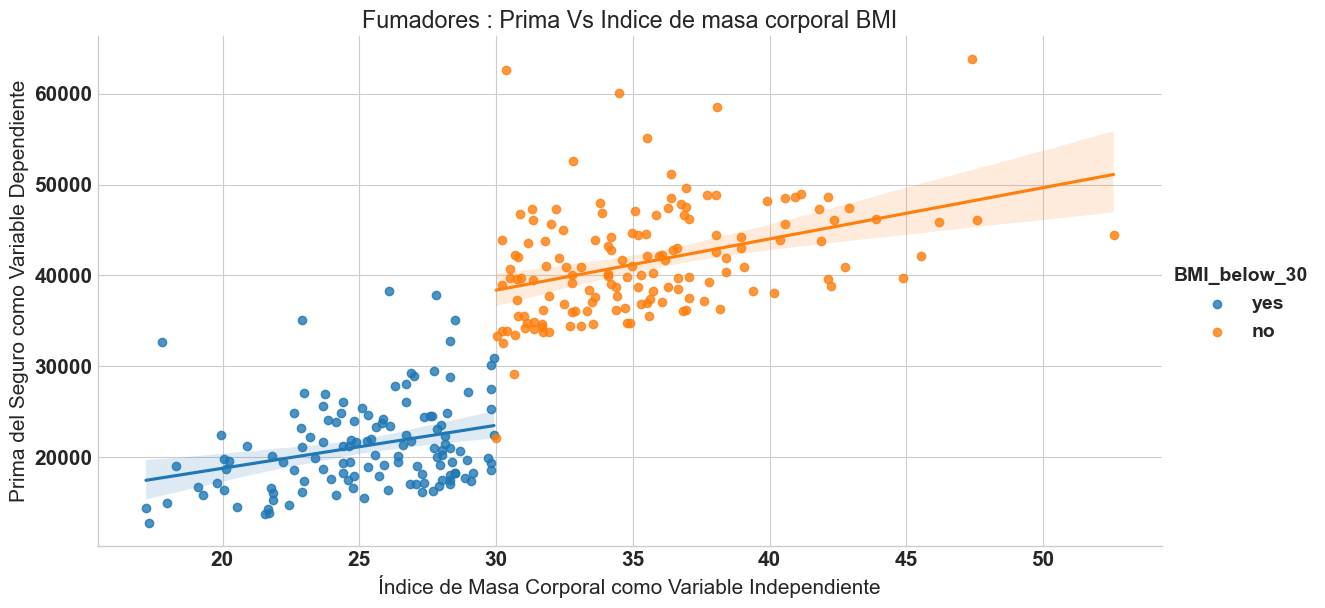

In [49]:
sns.lmplot(x='bmi',y='charges',hue='BMI_below_30', data=filter_smoker,aspect=2,height=6)
plt.xlabel('Índice de Masa Corporal como Variable Independiente')
plt.ylabel('Prima del Seguro como Variable Dependiente')
plt.title('Fumadores : Prima Vs Indice de masa corporal BMI');

In [50]:
print()
print('Resultados para FUMADORES por debajo de 30 de BMI')
print('============================')

print('Correlación spearman: ', below30_bmi['charges'].corr(below30_bmi['bmi'], method='spearman'))
print('Correlación kendall: ', below30_bmi['charges'].corr(below30_bmi['bmi'], method='kendall'))
print()
print('Resultados para FUMADORES por encima de 30 de BMI')
print('============================')

print('Correlación spearman: ', upper30_bmi['charges'].corr(upper30_bmi['bmi'], method='spearman'))
print('Correlación kendall: ', upper30_bmi['charges'].corr(upper30_bmi['bmi'], method='kendall'))
print()


Resultados para FUMADORES por debajo de 30 de BMI
Correlación spearman:  0.2911639610312381
Correlación kendall:  0.2018126594056577

Resultados para FUMADORES por encima de 30 de BMI
Correlación spearman:  0.4383848747547562
Correlación kendall:  0.3102767072791306



### Conclusiones : 
- Como podemos observar las correlaciones tanto por debajo como por encima de 30 BMI tienen correlaciones positivas
- Con valores que rondan los 0.3 para los que está por debajo de 30 
- Con valores que empizan en 0.3 y llegan (según el tipo de correlación) hasta los 0.43
- Respecto a las dispersiones de las correlaciones, podemos observar que para los fumadores por debajo de 30 de BMI es menor en los 25, donde se concentran la maypría de las muestras
- Y en lo que respecta a los que están por encima de 30 BMI la dispersión es menos en los 35 y se acrecenta mucho a partir de 40 BMI en adelante
- Por último destacar el gap exitente en el aumento de Primas entre los que están por debajo y por encima de 30 BMI

---

## Prima VS Edad : NO FUMADORES

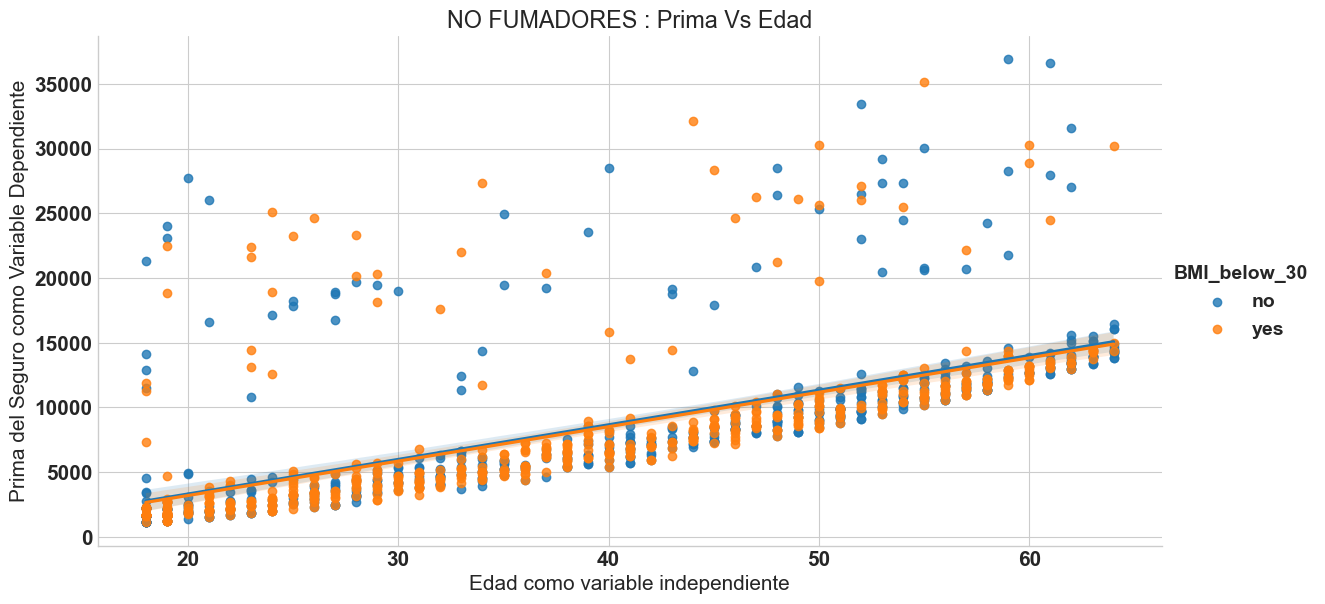

In [51]:
sns.lmplot(x='age',y='charges',hue='BMI_below_30',data=filter_no_smoker,aspect=2,height=6)
plt.xlabel('Edad como variable independiente')
plt.ylabel('Prima del Seguro como Variable Dependiente')
plt.title('NO FUMADORES : Prima Vs Edad');

In [52]:
print()
print('Resultados para NO FUMADORES por debajo de 30 de BMI')
print('============================')

print('Correlación spearman: ', below30_bmi_ns['charges'].corr(below30_bmi_ns['age'], method='spearman'))
print('Correlación kendall: ', below30_bmi_ns['charges'].corr(below30_bmi_ns['age'], method='kendall'))
print()
print('Resultados para NO FUMADORES por encima de 30 de BMI')
print('============================')

print('Correlación spearman: ', upper30_bmi_ns['charges'].corr(upper30_bmi_ns['age'], method='spearman'))
print('Correlación kendall: ', upper30_bmi_ns['charges'].corr(upper30_bmi_ns['age'], method='kendall'))
print()


Resultados para NO FUMADORES por debajo de 30 de BMI
Correlación spearman:  0.8275394355858631
Correlación kendall:  0.7380235834423464

Resultados para NO FUMADORES por encima de 30 de BMI
Correlación spearman:  0.8125114276622909
Correlación kendall:  0.7276376007295249



### Conclusiones : 
- Como podemos observar las correlaciones tanto por debajo como por encima de 30 BMI para los NO FUMADORES son altamente positivas respecto a las Primas y la Edad
- Con valores similares en ambos que rondan entre los 0.61 hasta los 0.8
- Con todo esto, podemos ver la enorme relación entre la edad y la prima de riesgo entre los NO Fumadores

---

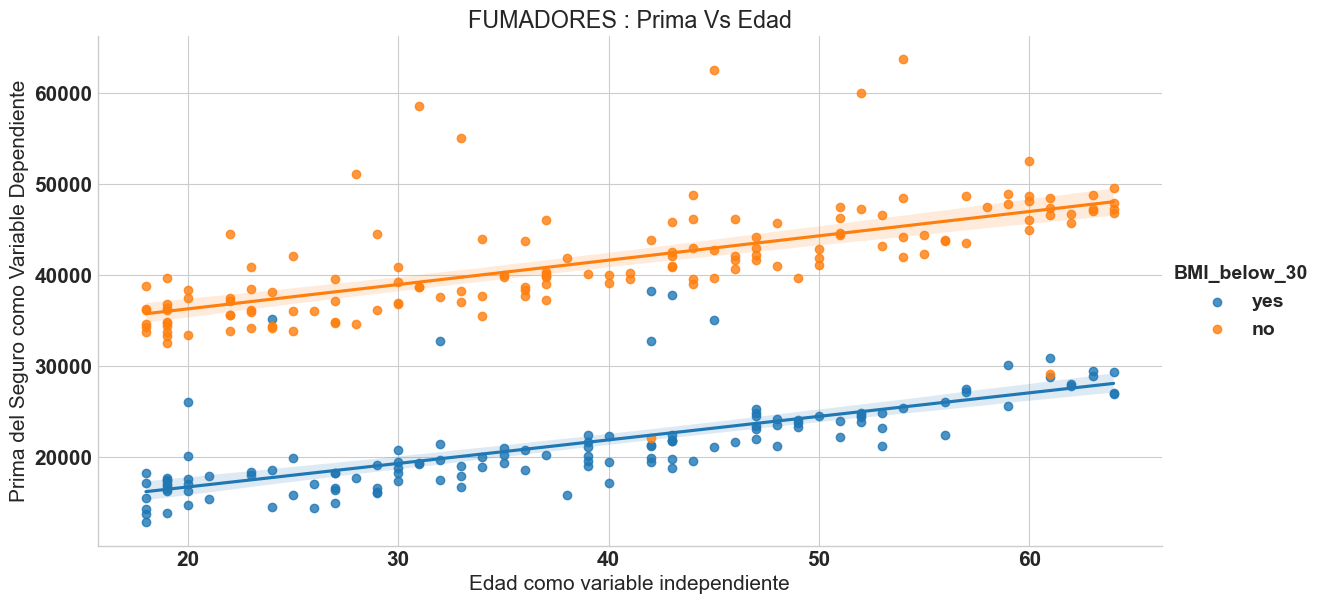

In [53]:
sns.lmplot(x='age',y='charges',hue='BMI_below_30',data=filter_smoker,aspect=2,height=6)
plt.xlabel('Edad como variable independiente')
plt.ylabel('Prima del Seguro como Variable Dependiente')
plt.title('FUMADORES : Prima Vs Edad');

In [54]:
print()
print('Resultados para FUMADORES por debajo de 30 de BMI')
print('============================')

print('Correlación spearman: ', below30_bmi['charges'].corr(below30_bmi['age'], method='spearman'))
print('Correlación kendall: ', below30_bmi['charges'].corr(below30_bmi['age'], method='kendall'))
print()
print('Resultados para FUMADORES por encima de 30 de BMI')
print('============================')

print('Correlación spearman: ', upper30_bmi['charges'].corr(upper30_bmi['age'], method='spearman'))
print('Correlación kendall: ', upper30_bmi['charges'].corr(upper30_bmi['age'], method='kendall'))
print()


Resultados para FUMADORES por debajo de 30 de BMI
Correlación spearman:  0.813844318598017
Correlación kendall:  0.6576659926399256

Resultados para FUMADORES por encima de 30 de BMI
Correlación spearman:  0.7698760313477595
Correlación kendall:  0.605032282169598



### Conclusiones : 
- Como podemos observar las correlaciones tanto por debajo como por encima de 30 BMI para los FUMADORES son altamente positivas respecto a las Primas y la Edad
- Con valores similares en ambos que rondan entre los 0.6 hasta los 0.8 , con mayor correlación los que están por debajode 30
- Con todo esto, podemos ver la enorme relación entre la edad y la prima de riesgo entre los Fumadores, de la misma forma que la vimos entre los NO FUMADORES

---

## Estudio de distribuciones de las columnas categóricas

### Distribución de la Prima VS Región

Text(0.5, 1.0, 'Distribución del BMI VS Región')

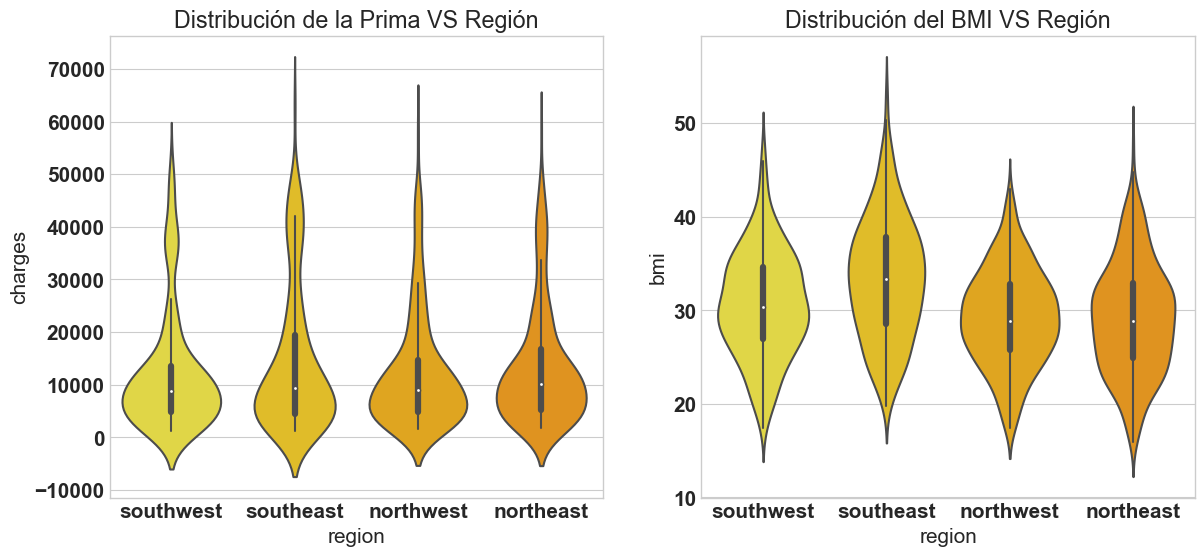

In [55]:
f = plt.figure(figsize=(14,6))

ax = f.add_subplot(121)
sns.violinplot(x='region', y='charges',data=insurance,palette='Wistia',ax=ax)
ax.set_title('Distribución de la Prima VS Región')

ax = f.add_subplot(122)
sns.violinplot(x='region', y='bmi',data=insurance,palette='Wistia',ax=ax)
ax.set_title('Distribución del BMI VS Región')

### Conclusiones:
- La distribución es uniforme entre la Prima y las regiones en todas las regiones, tanto a nivel de máximos y mínimos, como de concentración del número de muestras en las zona baja, por debajo de loa 10000 en Prima
- Debemos destar, eso sí, que en el caso del "southeast" tiene mos máximos mayores y mayores, encontrándose más distribuida, y especialmente ancha en valores altos, sobre 40000, respecto a las otras regiones.
- Tambíen destacar que respecto a BMI en la region de "southeast" tienen valores mínimos y máximos más altos, así como una distribución más homogenea a lo largo de todos los valores en comparación alas otras regiones que tienen una dispersión menor
---

### Distribución de la Prima VS Hijos

Text(0.5, 1.0, 'Distribución de la Prima VS Hijos')

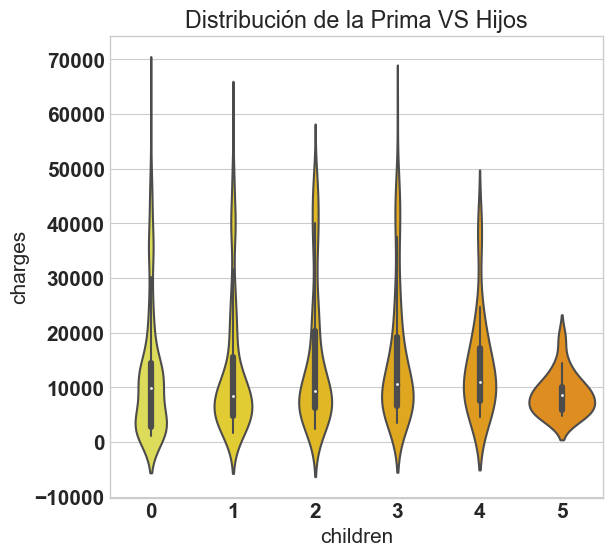

In [56]:
f = plt.figure(figsize=(14,6))

ax = f.add_subplot(122)
sns.violinplot(x='children', y='charges',data=insurance,palette='Wistia',ax=ax)
ax.set_title('Distribución de la Prima VS Hijos')


### Conclusiones:
- La distribución es uniforme independiente del número de hijos, tanto a nivel de máximos y mínimos, como de concentración del número de muestras en las zona baja, por debajo de loa 10000 en Prima
- Únicamente los de 2 y 4 hijos que están por debajo en los máximos, y mención especial para los de 5 que los máximos se reducen mucho y la concentración es mayoritaria en el rango de los 10000 de Prima
---

### Distribución de la Prima VS Sexo

Text(0.5, 1.0, 'Distribución de la Prima VS Sexo')

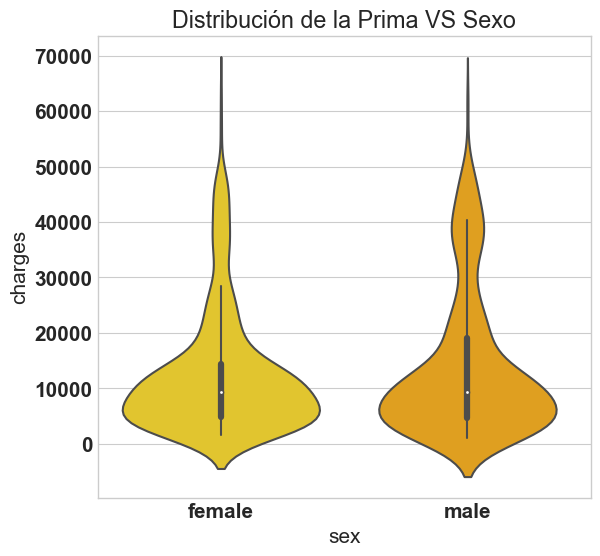

In [57]:
f = plt.figure(figsize=(14,6))

ax = f.add_subplot(121)
sns.violinplot(x='sex', y='charges',data=insurance,palette='Wistia',ax=ax)
ax.set_title('Distribución de la Prima VS Sexo')

### Conclusiones:
- La distribución es uniforme independiente del sexo, tanto a nivel de máximos y mínimos, como de concentración del número de muestras en las zona baja, por debajo de loa 10000 en Prima
---

### Distribución de la Prima VS Fumadores

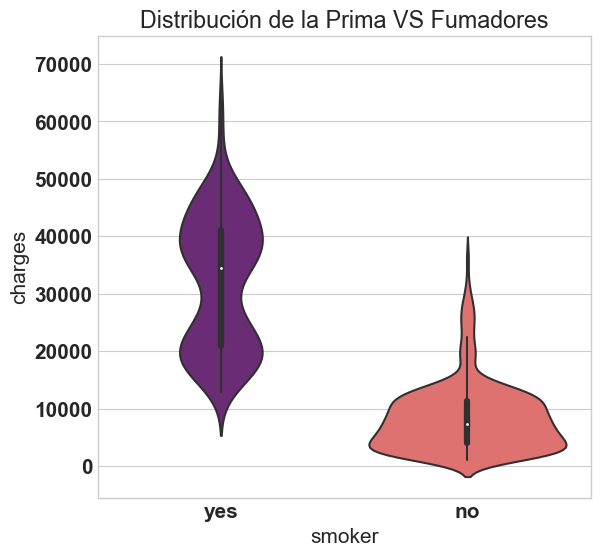

In [58]:
f = plt.figure(figsize=(14,6))

ax = f.add_subplot(122)
sns.violinplot(x='smoker', y='charges',data=insurance,palette='magma',ax=ax)
ax.set_title('Distribución de la Prima VS Fumadores');

### Conclusiones:
- En este caso podemos ver claramente la gran diferencia en la Prima del seguro respecto a ser o no fumador.
- Observamos que para los Fumadores la prima es más elevada, con mucha diferencia en los mínimos y máximos respectoa los NO Fumadores, y tambióen en la distribución que se ensancha en los valores de 20000 y 40000.
- Seguramente esta soble distribución en los Fumadores se deba a la diferencia entre los que tienen el BMI por debajode 30 y los que lo tienen por encima, como hemos visto en los estudios anteriores.
- Finalmente destacar la distribución de los NO Fumadores que está mayoritariamente muy por debajo de los 10000 de Prima

---

### Distribución de la Prima VS BMI en los NO FUMADORES

Text(0.5, 1.0, 'NO FUMADOR: Prima VS BMI por debajo de 30')

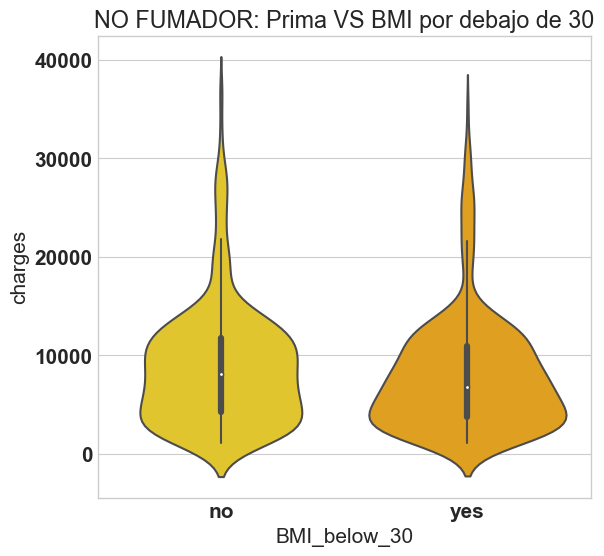

In [59]:
f = plt.figure(figsize=(14,6))

ax = f.add_subplot(121)
sns.violinplot(x='BMI_below_30', y='charges',data=filter_no_smoker ,palette='Wistia',ax=ax)
ax.set_title('NO FUMADOR: Prima VS BMI por debajo de 30')


### Conclusiones:
- En este caso vemos como para los NO FUMADORES, la diferencia entre estar por debajo y por encima de 30 de BMI afecta poco en la Prima de riesgo a pagar.

---

### Distribución de la Prima VS BMI en los FUMADORES

Text(0.5, 1.0, 'FUMADOR : Prima VS BMI por debajo de 30')

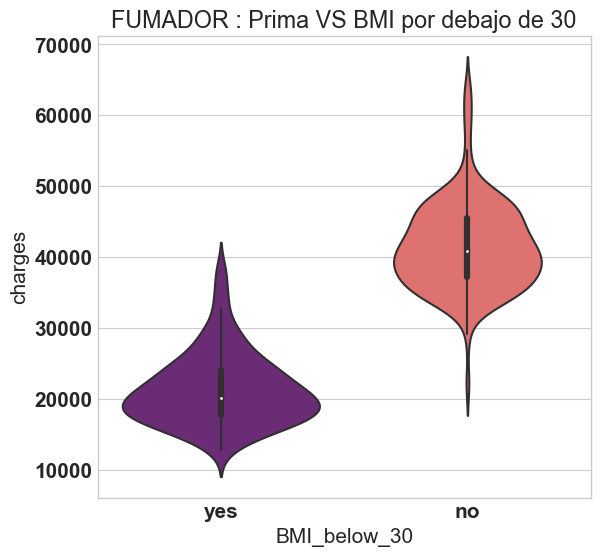

In [60]:
f = plt.figure(figsize=(14,6))

ax = f.add_subplot(122)
sns.violinplot(x='BMI_below_30', y='charges',data=filter_smoker ,palette='magma',ax=ax)
ax.set_title('FUMADOR : Prima VS BMI por debajo de 30')

### Conclusiones:
- Al contrario que el caso anterior, para  los FUMADORES; el tener el BMI por debajo o por encima de 30, crea una gran diferencia a la hora de pagar la PRima del seguro, tanto en mínimos y máximos, como en distribución de la mayoría de las cuantías, que para los que están por debajode 30 de BMI se sitúan en los 20000 y sobre los 40000, el doble, para los que est´´an por encima de 30 de BMI

---
---
---

## CONCLUSIONES FINALES DEL ESTUDIO ESTADÍSTICO

- La mayor correlación existente para la Prima del seguro la encontramos en la Edad, para todos los casos en general:
  - llegando al 0.82 en los NO FUMADORES por debajode 30 de BMI
  - y a los 0.81 en los FUMADORES por debajo de 30 de BMI
- La mayor diferencia de correlación existente por valor categórico, lo encontramos entre los FUMADORES y NO FUMADORES respecto a su BMI
  - que llega desde los apenas 0.1 para los NO FUMADORES
  - y que sobrepasa los 0.8 en el caso de los FUMADORES
- Finalmente destacar a parte de la correlación lineal observable, que los gap de subida de la Prima de Riesgo, se encuentran en 3 niveles
  - El primero , y más bajo, para los NO FUMADORES
  - El segundo para los FUMADORES por DEBAJO de 30 de BMI
  - El tercero para los FUMADORES por ENCIMA de 30 BMI
- Estos anteriores niveles descrito pagan el doble entre uno y otro, independientemente de su edad
- Finalmente mencionar el caso atípico de la región "southeast" que muestra:
  - En general una menor correlación lineal positiva que el resto.
  - Una distribución menor en los valores bajos y mayores en los altos.
  - Una gran dispersión general mayor, y en concreto en los valores altos, respecto a otras regiones
  - Unos mínimos y máximos de pago de Primas mayores que el resto.

---

---

---



# Entrenando modelos de regresión
---

Revisamos el Datasets para revisarlos antes de usarlos en los entrenamientos del modelo

Usaremos el modelo normalizado "insurance_norm"

In [240]:
insurance_norm.info()
insurance_norm.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           1338 non-null   float64
 1   bmi           1338 non-null   float64
 2   children      1338 non-null   int64  
 3   charges       1338 non-null   float64
 4   female        1338 non-null   float64
 5   male          1338 non-null   float64
 6   no smoker     1338 non-null   float64
 7   smoker        1338 non-null   float64
 8   northeast     1338 non-null   float64
 9   northwest     1338 non-null   float64
 10  southeast     1338 non-null   float64
 11  southwest     1338 non-null   float64
 12  BMI_below_30  1338 non-null   int32  
dtypes: float64(11), int32(1), int64(1)
memory usage: 130.8 KB


,age,bmi,children,charges,female,male,no smoker,smoker,northeast,northwest,southeast,southwest,BMI_below_30
0,19.0,27.900,0,16884.92400,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
1,18.0,33.770,1,1725.55230,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0
2,28.0,33.000,3,4449.46200,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0
3,33.0,22.705,0,21984.47061,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1
4,32.0,28.880,0,3866.85520,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1


### 
---

## Creación del Train y Test Set
---

Primeramente generaremos una semilla de aletoriedad, que normalmente se usa el valor 42, que usaremos para barajar los índices del Dataset a la hora de realizar la división del Dataset de Entrenamiento del de Test

In [275]:
# plantamos una semilla
np.random.seed(42)

Necesitamos crear, del total de datos del Dataset, una subdivisión. Una parte será para entrenar al modelo (TrainSet) y otro para comprobar el resultado del entrenamiento (TestSet)

Creamos una función para este trabajo llamada "split_train_test", para separ dichos Set

Aquí podemos ver la función np.random.permutation, a la que hemos previamente configurado con la semilla "42", para que baraje de forma "aleatoria" los índices, tanto del dataset de entrenamiento, como el de Test

In [276]:
def split_train_test(data, test_ratio):
    test_set_size  =int(len(insurance_norm)*test_ratio)
    shuffle_indices=np.random.permutation(len(data))
    test_indices   =shuffle_indices[:test_set_size]
    train_indices  =shuffle_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

Aplicaremos normalmente una división 80/20. Otros ratios pueden ser 70:30, 60:40, e incluso 50:50, pero en este caso usaremos el primero, ya que es el más común.

In [277]:
# Agreagamos el ratio de split
ratio = 0.2
# Ejecutamos la función
X_train, X_test = split_train_test(insurance_norm, ratio)
# Revisamos el número de filas en cada Set
print('Número de filas Total del dataset : ',len(insurance_norm))
print('Ratio : ', 100-100*ratio, '/',ratio*100) 
print('Número de filas por dataset :')
print('TrainSet : ',len(X_train))
print('TestSet  : ', len(X_test))


Número de filas Total del dataset :  1338
Ratio :  80.0 / 20.0
Número de filas por dataset :
TrainSet :  1071
TestSet  :  267


Una vez que tenemos el Dataset de entrenamiento (X_train), creamos una copia con la columna de resultados, que llamaremos "y_train" y eliminaremos dicha columna del Dataset de entrenameiento (X_train)

In [278]:
# Creamos un nuevo Dataset con la columna Charges a predecir con el modelo
y_train = X_train["charges"].copy()
# Eliminamos dicha columna para el modelo de entrenamiento
X_train = X_train.drop("charges", axis=1)

Comprobamos "y_train"

In [279]:
y_train

846      9872.70100
560      9193.83850
1285     8534.67180
1142    27117.99378
969      8596.82780
           ...     
1095     4561.18850
1130     8582.30230
1294    11931.12525
860     46113.51100
1126    10214.63600
Name: charges, Length: 1071, dtype: float64

## Mejorando la evaluación por medio de la validación cruzada
---

Llamada a la función para usarla en cada modelo

In [298]:
from sklearn.model_selection import cross_val_score

Creación de función pra imprimir los SCORES

In [299]:
def display_scores(scores):
    print(f"Scores: {scores}")
    print(f"Mean:   {scores.mean()}")
    print(f"Standard deviation:    {scores.std()}")

## Entrenando y evaluando : Regresión lineal
---

In [300]:
from sklearn.linear_model import LinearRegression

Seleccionamos el modelo de Regresión Lineal

In [301]:
lin_reg = LinearRegression()

Entrenamos al modelo X_train con los resultados y_train

In [302]:
lin_reg.fit(X_train, y_train)

LinearRegression()

Generamos las prediciones con el modelo entrenado y las comparamos con los valores reales (sólo 10):

In [303]:
# numero de predicciones
number = 10
#  Tomamos el número de predicciones de los datasets
some_data = X_train.iloc[:number]
some_labels = y_train.iloc[:number]
# Realizamos las predicciones sobre la muestra elegida
prediction = lin_reg.predict(some_data)
# Mostramos los resultados
print('Predicción          ||   Resultado esperado')
print('===========================================')
for x in range(number):
    print(prediction[x],'\t', list(some_labels)[x])

Predicción          ||   Resultado esperado
13016.654255183797 	 9872.701
7619.918349914393 	 9193.8385
8012.6853718700395 	 8534.6718
8843.84801952972 	 27117.99378
11916.85561569034 	 8596.8278
10276.830669959454 	 12475.3513
16877.02428541856 	 13405.3903
768.9160330894038 	 2150.469
23826.665695220272 	 13747.87235
11877.957142173618 	 6610.1097


### Comprobar los índices de rendimiento del estimador del modelo lineal

Para ello crearemos una variable con las predicciones del todo el Dataset de entrenamiento

In [306]:
lin_predictions = lin_reg.predict(X_train)

A partir de aquí calcularemso diferentes funciones y medidas de rendimiento para poder compararlo con otros métodos de entrenamiento

### Calculamos el Error Cuadrático Medio (ECM ó MSE), mediante la siguiente formula :

$$ MSE = \frac{1}{n}∑_{i=1}^{n}{(y_i-y_i')}^2 $$

El error cuadrático medio (ECM ó MSE) es una función de Rendimiento.

Mide el promedio de los errores al cuadrado, es decir, la diferencia entre el estimador y lo que se estima.

Es mejor usarla cuando hay grandes errores.

Se utiliza para comparar la precisión entre diferentes métodos o criterios de pronóstico.

Hay que comentar que da mucho más peso a los valores fuera de rango(outliers), que otras métricas como el MAE. (Error Absoluto Medio)

### Al final calculamos la Raiz del Error cuadrático Medio (RMSE), para que nos devuelva el resultado en la misma medida que la categoría que estamos modelando, en este caso "Charges" para los pagos de la Prima del Seguro

In [307]:
from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(y_train, lin_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

6031.7519680294

### Conclusión:
- Con un valor de 6031, el RMSE , nos dice que el error entre el máximo de pago de Prima y el mínimo, puede llegar a tener una media máxima de 6031 por encima y por debajo, lo cual tampoco es un gran logro, teniendo en cuenta que los rangos van desde:

In [308]:
print('Máximo : ',round(insurance['charges'].max() ))
print('Mínimo :  ',round(insurance['charges'].min() ))
print('Media  : ',round(insurance['charges'].mean()))

Máximo :  63770
Mínimo :   1122
Media  :  13270


- por lo que un error de 6000 corresponde a la mitad de la media, y por eso no muy buen estimador.


### Calculamos el Error absoluto medio (EAM ó MAE), mediante la siguiente formula :

$$ MAE = \frac{1}{n}∑_{i=1}^{n}{|y_i-y_i'|} $$

El Error absoluto medio (MAE), es también una función de rendimiento.

Es el promedio de la diferencia(error) absoluta entre el valor observado y los valores predichos.

Es un medidor más robusto, ya que no le da tanta importancia los valores atípicos.

Este estimador ya nos devuelve el resultado en las mismas unidades que la columna de resultados que queremos modelar, en este caso "Charges" correspondiente a la cuantía de la Prima del Seguro

In [309]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(y_train, lin_predictions)
lin_mae

4245.832766385123

### Validación cruzada sobre Regresión Lineal

In [322]:
lin_scores = cross_val_score(lin_reg, X_train, y_train, scoring = "neg_mean_squared_error", cv = 10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)


Scores: [6032.2789144  6660.16747787 5081.28797415 5840.54632493 5785.02281756
 5931.01820297 7173.87553049 6228.36704542 6198.31682186 5731.88247293]
Mean:   6066.276358257432
Standard deviation:    534.2958213778753


### Conclusión:
- Con un valor de 4245, el MAE , nos dice que la media del error (sin contar los outliers) entre el máximo de pago de Prime y el mínimo, puede llegar a tener una media de error de 4245, lo cual tampoco es un gran logro, teniendo en cuenta que los rangos van desde:

In [310]:
print('Máximo : ',round(insurance['charges'].max() ))
print('Mínimo :  ',round(insurance['charges'].min() ))
print('Media  : ',round(insurance['charges'].mean()))

Máximo :  63770
Mínimo :   1122
Media  :  13270


- por lo que un error de más de 4000 corresponde a la tercera parte de la media, y por eso no muy buen estimador.

---
---

## Entrenando y evaluando : Árbol de decisión
---

In [312]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor()

### Calculo de la función de rendimiento RMSE

In [313]:
tree_predictions = tree_reg.predict(X_train)
tree_mse = mean_squared_error(y_train, tree_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

493.97520812856715

### Calculo de la función de rendimiento MAE

In [314]:
tree_mae = mean_absolute_error(y_train, tree_predictions)
tree_mae

29.544903267973854

### Validación cruzada sobre árboles de decisión

In [321]:

tree_scores = cross_val_score(tree_reg, X_train, y_train, scoring = "neg_mean_squared_error", cv = 10)
tree_rmse_scores = np.sqrt(-tree_scores)
display_scores(tree_rmse_scores)

Scores: [5967.27016194 6603.97867066 6890.55827303 7299.12757935 7141.15024478
 6301.56743882 7558.67574466 7555.76517899 6709.94091839 5540.07306637]
Mean:   6756.810727699558
Standard deviation:    638.5651312693417


### Conclusión:
- Es un estimador mucho mejor que la Regresión Lineal

---
---

## Entrenando y evaluando : Random Forest
---

**Note**: we specify `n_estimators=100` to be future-proof since the default value is going to change to 100 in Scikit-Learn 0.22 (for simplicity, this is not shown in the book).

In [316]:

from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators = 100, random_state=42)

forest_reg.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

### Calculo de la función de rendimiento RMSE

In [263]:
forest_predictions = forest_reg.predict(X_train)
forest_mse = mean_squared_error(y_train, forest_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

1868.7512687394142

### Calculo de la función de rendimiento MAE

In [264]:
forest_mae = mean_absolute_error(y_train, forest_predictions)
forest_mae

1039.3683779470127

### Random Forest con Validación cruzada

In [265]:

forest_scores = cross_val_score(forest_reg, X_train, y_train, scoring="neg_mean_squared_error", cv= 10)

forest_rmse_scores =  np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)


Scores: [4788.01542847 5317.8151682  3829.04182109 4499.20532009 5257.71370287
 5024.26150117 5778.22431894 5448.32617312 5132.18947957 4659.31694659]
Mean:   4973.410986012268
Standard deviation:    526.1165245270511


### Conclusión:
- Es un estimador bastante bueno, aunque no tanto como el de los Árboles de decisión

---
---

## Entrenando y evaluando :  Support Vector Regression

---

### Calculo de la función de rendimiento RMSE

In [318]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(X_train, y_train)
svm_predictions = svm_reg.predict(X_train)
svm_mse = mean_squared_error(y_train, svm_predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

12790.621958923144

### Calculo de la función de rendimiento MAE

In [319]:
svm_mae = mean_absolute_error(y_train, svm_predictions)
svm_mae

6544.365229210854

### Conclusiones:
- No es un buen modelo de regresión

---
---

### Validación cruzada de SVR 

In [320]:


svm_scores = cross_val_score(svm_reg, X_train, y_train, scoring="neg_mean_squared_error", cv= 10)

svm_rmse_scores =  np.sqrt(-svm_scores)
display_scores(svm_rmse_scores)


Scores: [13060.22954518 12585.06654307 12571.57627705 15088.51165189
 12913.04286565 10554.33679535 13110.18825634 12523.08295302
 12898.041883   12338.58687032]
Mean:   12764.266364086876
Standard deviation:    1041.2399276024175


## Entrenando y evaluando :  XGBoost
---

"xgboost" algoritmo similar a random forest, pero en vez de hacerlo en paralelo, lo hace en serie pasando la salida con la entrada del siguiente, puliendo el resultado

### Calculo de la función de rendimiento RMSE

In [326]:
import xgboost as xgb

xgb_reg = xgb.XGBRegressor(objetive= "reg:squarederror", random_state=42)

xgb_reg.fit(X_train, y_train)
xgb_predictions=xgb_reg.predict(X_train)
xgb_mse=mean_squared_error(y_train, xgb_predictions)
xgb_rmse=np.sqrt(xgb_mse)
xgb_rmse

[15:05:49] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




969.5682838717088

### Calculo de la función de rendimiento MAE

In [327]:
xgb_mae = mean_absolute_error(y_train, xgb_predictions)
xgb_mae

521.3156115497344

### Validación cruzada sobre XGBoost

In [328]:
xgb_scores = cross_val_score(xgb_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
xgb_rmse_scores = np.sqrt(-xgb_scores)
display_scores(xgb_rmse_scores)

[15:05:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:05:51] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "objetive" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:05:52] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: {

### Conclusión:
- Es un modelo bastante bueno, pero no tanbueno en estew caso como Árboles de Decisión

---
---

# CONCLUSIONES de los Modelos de Regresión

---

## Comparación de los Modelos más efectivos

In [347]:
print('{:17} {:11} {:10}'.format('Modelo', 'RMSE', 'MAE'))
print('=================================')
print('{:16} {:5} {:10}'.format('Reg. Lineal',round(lin_rmse), round(lin_mae)))
print('{:16} {:5} {:10}'.format('Dec. Tree',round(tree_rmse), round(tree_mae)))
print('{:16} {:5} {:10}'.format('Ran. Forest',round(forest_rmse), round(forest_mae)))
print('{:16} {:5} {:10}'.format('Sup.Vec.Reg.',round(svm_rmse), round(svm_mae)))
print('{:16} {:5} {:10}'.format('XGBoost',round(xgb_rmse), round(xgb_mae)))

Modelo            RMSE        MAE       
Reg. Lineal       6032       4246
Dec. Tree          494         30
Ran. Forest       1869       1039
Sup.Vec.Reg.     12791       6544
XGBoost            970        521


### Conclusión :
- Como podemos observar el mejor modelo, es Árboles de Decisión con un RMSE de 494 y un MAE de 30

---
---

# Evaluando el modelo con el Test Set
---

In [348]:
y_test = X_test["charges"].copy()
X_test = X_test.drop("charges", axis=1)


In [349]:
final_predictions = tree_reg.predict(X_test)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

7113.469792110752